### Imports

In [4]:
import random
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
from localbot_localization.src.models.pointnet import PointNet, feature_transform_regularizer
from localbot_localization.src.dataset import LocalBotDataset
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from torch.autograd import Variable

torch.Size([100000, 3])


### Load the dataset

In [5]:
train_dataset = LocalBotDataset(seq=110, npoints=2000)
test_dataset = LocalBotDataset(seq=111, npoints=2000)
batch_size = 4

### Pytorch data loader

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=2)
# Num_workers tells the data loader instance how many sub-processes to use for data loading. If the num_worker is zero (default) the GPU has to wait for CPU to load data.

In [7]:
print(len(train_dataset), len(test_dataset))

92 23


### Build the model

In [8]:
feature_transform = False # lets use feature transform
model = PointNet(feature_transform=feature_transform)


### Optimizer and Loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # the most common optimizer in DL
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) # variable learning rate. After 5 epochs, the lr decays 0.5
criterion = nn.MSELoss() # TODO: search for a better loss function!! Should we predict the translaction and rotation separately?? RESEARCH!

In [10]:
model.cuda() # move all model parameters to the GPU

PointNet(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2

In [11]:
num_batch = len(train_dataset) / batch_size

### Training loop

In [12]:
n_epochs = 20
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for epoch in range(n_epochs):
    t0 = datetime.now()
    scheduler.step() # here we are telling the scheduler that: n_epochs += 1
    train_loss = []
    for i, data in enumerate(train_dataloader):
        points, target = data
        #points.shape --> 2,10000,3
        #target.shape --> 2,6
    
        points = points.transpose(2, 1) # 3xN which is what our network is expecting
        points, target = points.cuda(), target.cuda() # move data into GPU
        
        optimizer.zero_grad() # Clears the gradients of all optimized tensors (always needed in the beginning of the training loop)
        
        model = model.train() # Sets the module in training mode. For example, the dropout module can only be use in training mode.
        
        #print(points.shape)
        
        pred, trans, trans_feat = model(points) # our model outputs the pose, and the transformations used,
            
        loss = criterion(pred, target)
        
        if feature_transform:
            loss += feature_transform_regularizer(trans_feat) * 0.001 ## Regularization! --> Prevent overfitting by adding something to the cost function. The simpler the model the lower the cost function
        
        
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves.
        optimizer.step() # Performs a single optimization step (parameter update).
        
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    
    test_loss=[]
    for i, data in enumerate(train_dataloader):
        points, target = data
        points = points.transpose(2, 1) # 3xN which is what our network is expecting
        points, target = points.cuda(), target.cuda() # move data into GPU
        model = model.eval() # Sets the module in evaluation mode.

        pred, _, _ = model(points)
        
        loss = criterion(pred, target)
        
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    
    dt = datetime.now() - t0
    print(f'epoch {epoch+1}/{n_epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, duration: {dt}')
        
        
        
    

/home/danc/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 1/20, train_loss: 2.4788, test_loss: 1.9078, duration: 0:00:02.268560
epoch 2/20, train_loss: 1.2656, test_loss: 1.4941, duration: 0:00:01.901663
epoch 3/20, train_loss: 1.1945, test_loss: 2.4435, duration: 0:00:02.042171
epoch 4/20, train_loss: 1.2272, test_loss: 1.5023, duration: 0:00:01.990438
epoch 5/20, train_loss: 1.2321, test_loss: 1.7633, duration: 0:00:01.966587
epoch 6/20, train_loss: 1.1998, test_loss: 1.6708, duration: 0:00:01.997691
epoch 7/20, train_loss: 1.1839, test_loss: 1.5910, duration: 0:00:01.893593
epoch 8/20, train_loss: 1.1425, test_loss: 1.5878, duration: 0:00:01.911505
epoch 9/20, train_loss: 1.1656, test_loss: 1.4732, duration: 0:00:02.037867
epoch 10/20, train_loss: 1.1892, test_loss: 1.4497, duration: 0:00:01.981823
epoch 11/20, train_loss: 1.1983, test_loss: 1.3834, duration: 0:00:02.147793
epoch 12/20, train_loss: 1.1640, test_loss: 1.3229, duration: 0:00:01.972669
epoch 13/20, train_loss: 1.1635, test_loss: 1.3728, duration: 0:00:02.023202
epoch 14

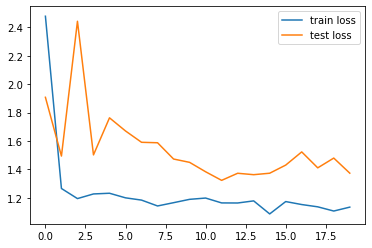

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'pointnet.pth')

In [ ]:
sim_data = Variable(torch.rand(1,3,10000)).cuda()   # batch size = 32, 3 features, n_points = 2500

In [ ]:
model(sim_data)[0].cpu().detach().numpy()